<a href="https://colab.research.google.com/github/franlopez1234/7506R-1C2023-GRUPO17/blob/Ensambles/ensambles_svc_rf_knn_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Librerias

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, make_scorer)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
import seaborn as sns
import sklearn as sk
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

##Realizamos el tratamiento de las variables

In [4]:
df_hotels_train = pd.read_csv('hotels_train.csv')

In [5]:
df_hotels_train.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.5,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.0,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0


In [6]:
#Eliminamos las columnas de reservation_status y reservation_status_date para evitar confusiones
df_hotels_train = df_hotels_train.drop(['reservation_status','reservation_status_date'], axis =1) #->Desmarcar al abrir el archivo
df_hotels_train.dtypes

hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           

In [7]:
df_hotels_train['hotel'] = df_hotels_train['hotel'].astype('string')
df_hotels_train['arrival_date_month'] = df_hotels_train['arrival_date_month'].astype('string')
df_hotels_train['meal'] = df_hotels_train['meal'].astype('string')
df_hotels_train['country'] = df_hotels_train['country'].astype('string')
df_hotels_train['id'] = df_hotels_train['id'].astype('string')
df_hotels_train['customer_type'] = df_hotels_train['customer_type'].astype('string')
df_hotels_train['market_segment'] = df_hotels_train['market_segment'].astype('string')
df_hotels_train['distribution_channel'] = df_hotels_train['distribution_channel'].astype('string')
df_hotels_train['reserved_room_type'] = df_hotels_train['reserved_room_type'].astype('string')
df_hotels_train['assigned_room_type'] = df_hotels_train['assigned_room_type'].astype('string')
df_hotels_train['deposit_type'] = df_hotels_train['deposit_type'].astype('string')

Retiramos los nulos

In [8]:
#Company
df_hotels_train['company'].fillna(-9999, inplace=True)

In [9]:
#Agent
df_hotels_train['agent'].fillna(-9999, inplace=True)

In [10]:
#Country
df_hotels_train['country'].fillna('PRT', inplace=True)

In [11]:
#Children
df_hotels_train['children'].fillna(0, inplace=True)

Analizamos los outliers

In [12]:
#columnas:(lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, required_car_parking_spaces)
media_lead_time=np.mean(df_hotels_train.lead_time)
std_lead_time=np.std(df_hotels_train.lead_time)
df_zscore = pd.DataFrame()
df_zscore['z_lead_time']=(df_hotels_train.lead_time - media_lead_time)/std_lead_time
df_zscore[df_zscore['z_lead_time']>3]


,z_lead_time
15,3.186066
51,3.402834
95,3.086713
426,3.691859
576,4.640223
...,...
61579,3.655731
61695,3.213162
61761,3.466059
61783,3.086713


In [13]:
for i in range(len(df_zscore['z_lead_time'])):
  if df_zscore.z_lead_time[i] > 3:
    df_hotels_train.lead_time[i] = round(media_lead_time)

<ipython-input-13-6a0a74c2d425>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.lead_time[i] = round(media_lead_time)


In [14]:
#Normalizamos previus cancellation
for i in range(len(df_hotels_train.previous_cancellations)):
  if df_hotels_train.previous_cancellations[i] > 10:
    df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

<ipython-input-14-66f8767a13d8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [15]:
media_previous_bookings_not_canceled=np.mean(df_hotels_train.previous_bookings_not_canceled)
for i in range(len(df_hotels_train.previous_bookings_not_canceled)):
  if df_hotels_train.previous_bookings_not_canceled[i] > 30:
    df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)

<ipython-input-15-c7822855a731>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)


In [16]:
#Normalizamos los valores atipicos de booking change
for i in range(len(df_hotels_train.booking_changes)):
  if df_hotels_train.booking_changes[i] > 10:
    df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

<ipython-input-16-83ddfe064c16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [17]:
media_days_in_waiting_list = np.mean(df_hotels_train.days_in_waiting_list)

for i in range(len(df_hotels_train.days_in_waiting_list)):
  if df_hotels_train.days_in_waiting_list[i] > 100:
    df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)

<ipython-input-17-bc59f9949979>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)


In [18]:
media_required_car_parking_spaces = np.mean(df_hotels_train.required_car_parking_spaces)

for i in range(len(df_hotels_train.required_car_parking_spaces)):
  if df_hotels_train.required_car_parking_spaces[i] > 7:
    df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)

<ipython-input-18-d22d66d29b29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)


In [19]:

df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

In [20]:
df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] <= 2 and df_hotels_train.babies[i] >= 8:
    df_hotels_train = df_hotels_train.drop(index = [i])
    

df_hotels_train.reset_index(drop=True, inplace=True)

In [21]:
media_adults=np.mean(df_hotels_train.adults)

for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] >= 25:
    df_hotels_train.adults[i] = round(media_adults)

<ipython-input-21-8ab05d604988>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.adults[i] = round(media_adults)


In [22]:
df_hotels_train.reset_index(drop=True, inplace=True)

for i in range(len(df_hotels_train)):
  if df_hotels_train.stays_in_week_nights[i] == 0 and df_hotels_train.stays_in_weekend_nights[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

Eliminamos id (recordar que la vamos a necesitar mas tarde)

In [23]:
eliminar_columnas = ['id'] # -> Recordar que el id lo vamos a necesitar para machear en kaggle
                                                                      
df_hotels_train.drop(eliminar_columnas, axis='columns', inplace=True)

## Realizamos un encode de las variables

In [24]:
# Realizamos el one hot encoding, con scikit learn.
# Por cada columna a encodear, hacer un fit transform. Dropear la columna, y agregar las columnas nuevas con el nombre adecuado
df_hotels_train_to_encode = df_hotels_train.copy()
cols_a_encodear = ['hotel','arrival_date_month','customer_type','meal', 'distribution_channel','market_segment', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'country']
ohe = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist') # Siempre se elimina la primera columna, o el feature entero si solo tiene un valor (no aporta informacion).
transformer = make_column_transformer(
    (ohe, cols_a_encodear),
    remainder='passthrough',
    verbose_feature_names_out=False
)

Dropeamos "is_canceled" ya que no es necesario encodearla y la guardamos en un dataset para utilizarla mas adelante

In [25]:
df_target = df_hotels_train['is_canceled']
hotels_train_encoded = transformer.fit_transform(df_hotels_train_to_encode.drop('is_canceled', axis=1)) # Se dropea is_canceled, porque no hace falta encodearlo, y ademas la instancia de test no va a tener esa columna.

Encodeamos nuestras variables

In [26]:
df_hotels_train_encoded = pd.DataFrame(
    hotels_train_encoded.toarray(), 
    columns=transformer.get_feature_names_out()
)

#Mostramos las primera 10 columnas de country, ya que el resto tiene una cantidad bajisima de datos y no aportan demasiado
country_cols = df_hotels_train_encoded.columns[df_hotels_train_encoded.columns.str.startswith('country_')]
selected_columns = (df_hotels_train_encoded[country_cols] != 0).sum()
#top_cols = selected_columns.nlargest(10).index
top_cols = ['country_PRT', 'country_GBR', 'country_FRA', 'country_ESP',
       'country_DEU', 'country_ITA', 'country_IRL', 'country_BRA',
       'country_BEL', 'country_USA']
other_countries = [col for col in country_cols if col not in top_cols]
df_hotels_train_encoded['country_other'] = df_hotels_train_encoded[other_countries].sum(axis=1)
df_hotels_train_encoded.drop(other_countries, axis=1, inplace=True)   

##Ensambles

Dividimos el data set y copiamos 'is_canceled'

In [27]:
#Creo un dataset con los features que voy a usar para clasificar
df_hotels_train_x = df_hotels_train_encoded

#Creo un dataset con la variable target
df_hotels_train_y = df_hotels_train['is_canceled'].copy()

#Genero los conjuntos de train y test]
x_train, x_test, y_train, y_test = train_test_split(df_hotels_train_x, 
                                                    df_hotels_train_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

Creamos una funcion para mostrar nuestras metricas

In [28]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

# SVC

In [29]:
#Normalizo para luego utiizar en nuestro modelo
std_scaler = StandardScaler()
x_train_std = std_scaler.fit_transform(x_train)
x_test_std = std_scaler.transform(x_test)

Se utilizo GridSearch con los siguiente parametros: 
```
param_grid = {'C':[3,4,6,10,15,30],
              'kernel':['rbf','poly'],
              'gamma':[1,3,4,7,5,8,10]}
scorer_fn = make_scorer(sk.metrics.f1_score)
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring=scorer_fn, verbose=2, n_jobs=-1)
```
Como mejores hiper parametros obtuvimos:
```
{'kernel': 'rbf', 'C': 5, 'gamma': '10'}
```

Creamos nuestro modelo con los mejores hiper parametros que obtuvimos

In [56]:
#Creo un clasificador con kernel radial y lo entreno sobre los datos normalizados
svc = SVC(kernel='rbf', C=5, gamma=10)
svc.fit(x_train_std, y_train)


SVC(C=5, gamma=10)

Realizamos la prediccion y mostramos las metricas

              precision    recall  f1-score   support

           0       0.67      0.99      0.80      9219
           1       0.98      0.51      0.67      9216

    accuracy                           0.75     18435
   macro avg       0.83      0.75      0.73     18435
weighted avg       0.83      0.75      0.73     18435



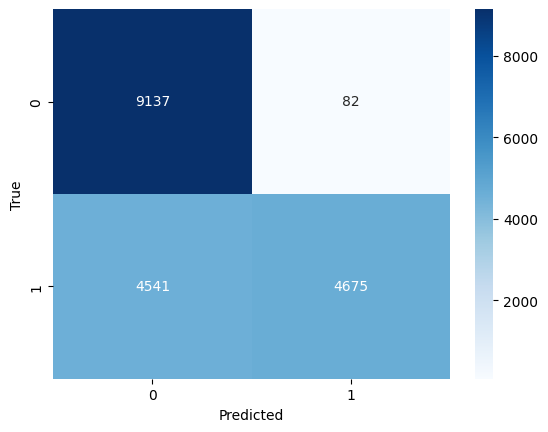

In [57]:
#Hago la predicción y calculo las métricas
y_svc_pred = svc.predict(x_test_std)
metricas(y_svc_pred, y_test)


# KNeighborsClassifier

Se utiliza MinMaxScaler.
Primer GridSearch con:
```
{'n_neighbors': [13, 14, 15, 16, 17],
              'weights': ['uniform', 'distance'],
              'algorithm': ['kd_tree']}
```
Obtuvimos como mejores hiper parametros:
```
{'algorithm': 'kd_tree', 'n_neighbors': 17, 'weights': 'distance'}
```
Segundo GridSearch con:
```
{'n_neighbors': [17, 18, 19, 20, 21, 22, 23],
              'weights': ['distance'],
              'algorithm': ['kd_tree']}
```
Obtuvimos como mejores hiper parametros:
```
{'algorithm': 'kd_tree', 'n_neighbors': 20, 'weights': 'distance'}
```

In [32]:
#Normalizo para luego utiizar en nuestro modelo
mm_scaler = MinMaxScaler()
x_train_mm = mm_scaler.fit_transform(x_train)
x_test_mm = mm_scaler.transform(x_test)

Creamos el modelo con los mejores hipera parametros hallados

In [33]:
# En base a lo anterior, se crea el modelo con los mejores hiper parámetros hallados.
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=20, weights='distance')
knn.fit(x_train_mm, y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=20, weights='distance')

Mostramos la matriz de confusion y nuestras metricas

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      9219
           1       0.78      0.85      0.81      9216

    accuracy                           0.81     18435
   macro avg       0.81      0.81      0.81     18435
weighted avg       0.81      0.81      0.81     18435



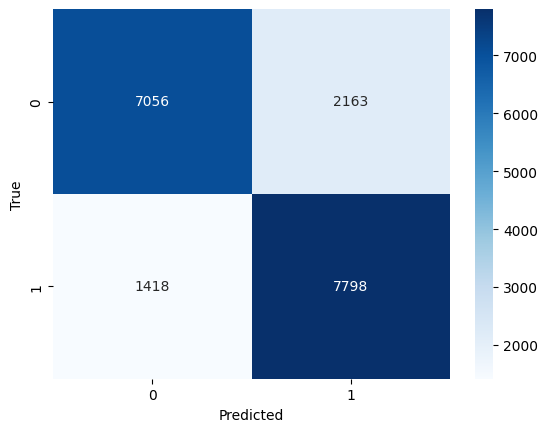

In [34]:
y_knn_pred = knn.predict(x_test_mm)
metricas(y_knn_pred, y_test)

# RandomForestClassifier

No se utiliza Scaler.
Primer GridSearch con:
```
{'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, 15, 20],
              'min_samples_split': [2, 5, 10]}
```
Obtuvimos como mejores hiper parametros:
```
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
```
Segundo GridSearch con:
```
{'n_neighbors': [17, 18, 19, 20, 21, 22, 23],
              'weights': ['distance'],
              'algorithm': ['kd_tree']}
```
Obtuvimos como mejores hiper parametros:
```
{'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 110}
```

In [35]:
rf = RandomForestClassifier(max_depth=23, min_samples_split=2, n_estimators=110)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=23, n_estimators=110)

Mostramos la matriz de confusion y las metricas que obtuvimos

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      9219
           1       0.88      0.88      0.88      9216

    accuracy                           0.88     18435
   macro avg       0.88      0.88      0.88     18435
weighted avg       0.88      0.88      0.88     18435



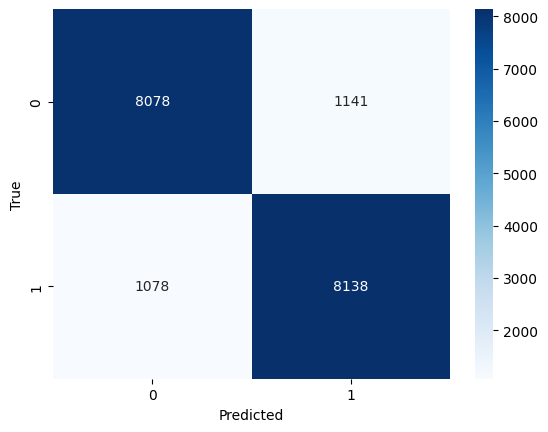

In [36]:
y_rf_pred = rf.predict(x_test)
metricas(y_rf_pred, y_test)

# XGBoost

In [37]:
#Separo un set de Evaluacion
x_train_Xg, x_test_Xg, y_train_Xg, y_test_Xg = train_test_split(df_hotels_train_encoded.values, 
                                                    df_target.values, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_target.values) #estratificado para mantener proporcion


print('# Datos Entrenamiento: {}'.format(len(x_train_Xg))) #- > cantidad de datos en cada set
print('# Datos Prueba: {}'.format(len(x_test_Xg)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train_Xg,y_test_Xg]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 49160
# Datos Prueba: 12290
% Positivos Entrenamiento: 50.201
% Positivos Prueba: 50.203


In [38]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state = 0)
xgb_model.fit(x_train_Xg, y_train_Xg) #Entrenamos el modelo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

AUC: 0.8729618859969703
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      6120
           1       0.87      0.88      0.87      6170

    accuracy                           0.87     12290
   macro avg       0.87      0.87      0.87     12290
weighted avg       0.87      0.87      0.87     12290



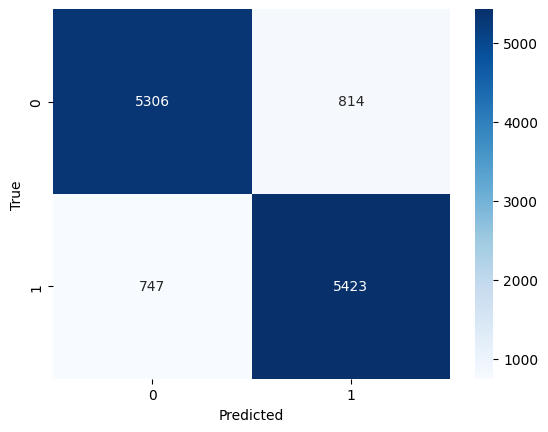

In [39]:
#Realizamos el pred y mostramos la matriz de confusion
y_pred_Xg = xgb_model.predict(x_test_Xg)
print('AUC:',roc_auc_score(y_test_Xg, y_pred_Xg)) 
metricas(y_pred_Xg,y_test_Xg)

Tenemos unas metricas bastante mas altas que el resto de ensambles en primera instancia. Este modelo es bastante mas potente que el resto de nuestros modelos hasta ahora.

Ahora, buscaremos los hiperparametros para optimizar el modelo y conseguir un mejor rendimiento

In [40]:

params_grid = {'n_estimators': [100,150,200,250],
              'max_depth': [1,5,10,15],
              'learning_rate': [1,0.5,0.3,0.2]}
#Folds
kfoldcv = StratifiedKFold(n_splits=5)

#Metrica que buscamos mejorar 
scorer_fn = make_scorer(sk.metrics.f1_score) 


#Ramdom Search CV
clasificador = xgb.XGBClassifier()
grid_cv = GridSearchCV(clasificador, params_grid, n_jobs=5, scoring = scorer_fn, cv=kfoldcv, verbose = 2)
grid_cv.fit(x_train_Xg,y_train_Xg)

print(grid_cv.best_score_, grid_cv.best_params_)

#Mejor Modelo
gb = grid_cv.best_estimator_


"\nparams_grid = {'n_estimators': [100,150,200,250],\n              'max_depth': [1,5,10,15],\n              'learning_rate': [1,0.5,0.3,0.2]}\n#Folds\nkfoldcv = StratifiedKFold(n_splits=5)\n\n#Metrica que buscamos mejorar \nscorer_fn = make_scorer(sk.metrics.f1_score) \n\n\n#Ramdom Search CV\nclasificador = xgb.XGBClassifier()\ngrid_cv = GridSearchCV(clasificador, params_grid, n_jobs=5, scoring = scorer_fn, cv=kfoldcv, verbose = 2)\ngrid_cv.fit(x_train_Xg,y_train_Xg)\n\nprint(grid_cv.best_score_, grid_cv.best_params_)\n\n#Mejor Modelo\ngb = grid_cv.best_estimator_\n"

Utilizamos grid search y variamos los "params_grid", en el mejor resultado obtener un f1_score de 0.883 con:
```
params_grid = {'n_estimators': [100,150,200,250],
              'max_depth': [1,5,10,15],
              'learning_rate': [1,0.5,0.3,0.2]}
```
Obtenemos  como mejores hiper parametros:
```
{n_estimators = 200 ,learning_rate = 0.2, max_depth = 10 }
```


Armamos el modelo con los mejores hiper parametros

In [41]:
xgb_H = xgb.XGBClassifier(n_estimators = 200 ,learning_rate = 0.2, max_depth = 10)
xgb_H.fit(x_train_Xg, y_train_Xg) #Entrenamos el modelo


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Graficamos la matriz de confusion y sus metricas

AUC: 0.8779395875043696
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6120
           1       0.88      0.88      0.88      6170

    accuracy                           0.88     12290
   macro avg       0.88      0.88      0.88     12290
weighted avg       0.88      0.88      0.88     12290



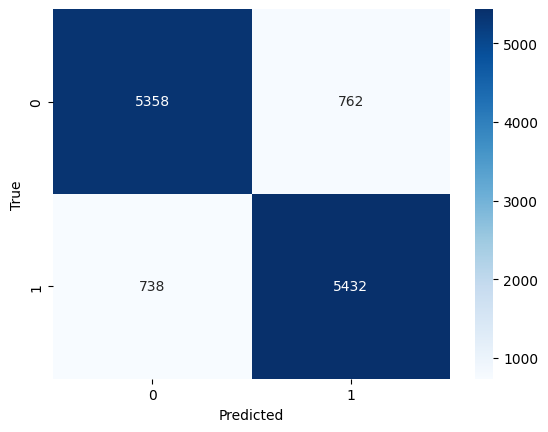

In [42]:
#Realizamos el pred y mostramos la matriz de confusion
y_pred_Xg = xgb_H.predict(x_test_Xg)
print('AUC:',roc_auc_score(y_test_Xg, y_pred_Xg)) 
metricas(y_pred_Xg,y_test_Xg)

Logramos mejorar las metricas y nuestra variable target aumento. 
Notemos que a un que hicimos varios grid search, no logramos aumentar "demasiado" nuestro f1_score. Esto se debe a que nuestras metricas en un inicio era bastante buenas (0.87). De igual manera, hay un aumento notorio con la busqueda hiper parametros.

##Stacking

En esta parte usaremos stacking, combinando nuestros tres mejores ensambes para poder lograr una mejor performance en nuestro modelo.

In [43]:
import numpy as np 
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


Creamos una funcion para evaluar el modelo

In [44]:
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    scores = cross_val_score(model, x, y, scoring='f1', cv=cv, n_jobs=1, verbose=1, error_score='raise')
    return scores

Creamos otra para el plot de resultados

In [45]:
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='f1_score',
    showlegend=False)
    fig.show()

Utilizamos minmax scaler



In [46]:
x_train_St, x_test_St, y_train_St, y_test_St = train_test_split(df_hotels_train_encoded.values, 
                                                    df_target.values, random_state = 42, train_size = 0.80)
min_max_scaler = preprocessing.MinMaxScaler()
x_train_St_minmax = min_max_scaler.fit_transform(x_train_St) 
x_test_St_minmax  = min_max_scaler.transform(x_test_St) 

Utilizamos los hiperparametros obtenidos anteriormente para Random forest, XGBoost y knn. Usando los modelos e hiperparametros por defecto de Stacking obtuvimos un score de 0.8476810414971522

In [47]:
base_models = {'random_forest':rf,
               'XGBoost': xgb_H,
               'knn': knn}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train_St_minmax, y_train_St)
    model_scores[name] = scores



Evaluating random_forest


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Evaluating knn


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.8min finished


Preparamos la base de modelo

In [48]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', rf),
               ('XGBoost', xgb_H),
               ('knn', knn)]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)


In [49]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, x_train_St_minmax, y_train_St)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.1s fini

In [50]:
#Grafico performance
plot_results(model_scores, name='stacking_model_cv')

Como observamos, nuestros mejores ensambles fueron claramente Xg y Rm. Knn bastante mas bajo , ademas observamos como mejoro un poco nuestro score con el stacking

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished


0.8855166802278275
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      6196
           1       0.88      0.89      0.88      6094

    accuracy                           0.89     12290
   macro avg       0.89      0.89      0.89     12290
weighted avg       0.89      0.89      0.89     12290



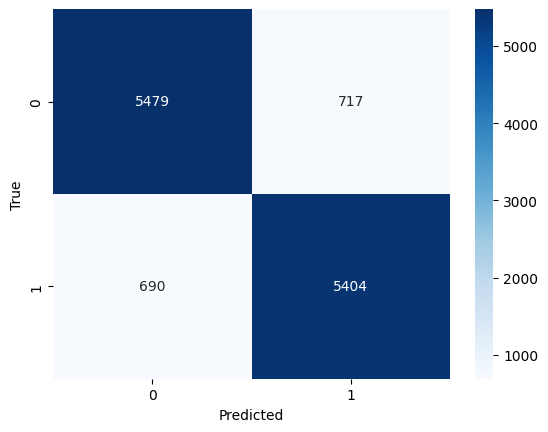

In [51]:
stacking_model.fit(x_train_St_minmax,y_train_St)
y_pred_st = stacking_model.predict(x_test_St_minmax)
metricas(y_pred_st,y_test_St)

Como se puede ver aqui pudimos mejorar el score hasta 0,89 utilizando los mejores modelos y hiper parametros encontrados previamente.

##Voting

Ahora utilizaremos el metodo de Votin para tratar de mejorar nuestras metricas

In [54]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6196
           1       0.88      0.88      0.88      6094

    accuracy                           0.88     12290
   macro avg       0.88      0.88      0.88     12290
weighted avg       0.88      0.88      0.88     12290



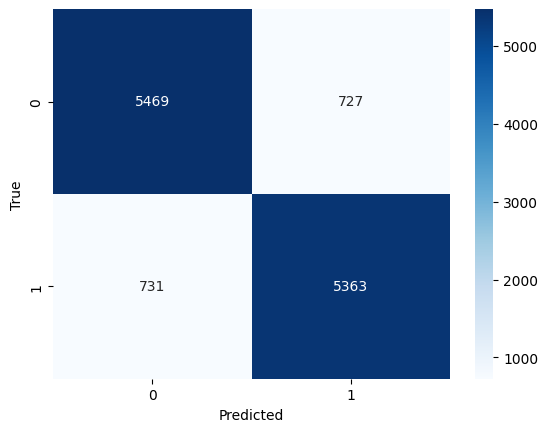

In [55]:
#Creo clasificadores
log_clf = LogisticRegression(max_iter=7000)
xgb_H_clf = xgb_H
rnd_clf = rf


#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('xgb', xgb_H_clf), ('rnd', rnd_clf), ('lr', log_clf)], voting = 'hard')

#Armo conjunto entrenamiento y test 80-20
x_train_Vt, x_test_Vt, y_train_Vt, y_test_Vt = train_test_split(df_hotels_train_encoded.values, 
                                                    df_target.values, random_state = 42, train_size = 0.80)


#Entreno el ensemble
vot_clf.fit(x_train_Vt, y_train_Vt)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test_Vt)
metricas(pred,y_test_Vt)

Utilizando voting, no notamos un aumento considerable en nuestras metricas  (tampoco empeoraron) esto se debe a que nuestros mejores modelos predicen bastante parecido.